# Ridge regression on data smoothed with Gaussian (n = 10)

In [1]:
library(tidyverse)

#install.packages('scales')
library(scales)

#install.packages("slider")
library(slider)

library(glmnet)

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ ggplot2 3.1.1     ✔ purrr   0.3.2
✔ tibble  3.1.4     ✔ dplyr   1.0.7
✔ tidyr   1.1.3     ✔ stringr 1.4.0
✔ readr   1.3.1     ✔ forcats 0.4.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

Attaching package: ‘scales’

The following object is masked from ‘package:purrr’:

    discard

The following object is masked from ‘package:readr’:

    col_factor

Loading required package: Matrix

Attaching package: ‘Matrix’

The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack

Loading required package: foreach

Attaching package: ‘foreach’

The f

In [2]:
sum_control_ATAC_bin_rm_gaussian_mean <- read.csv("data/sum_control_normalized_gaussian_smooth_ATAC_bin_rm.csv")
ATAC_val <- sum_control_ATAC_bin_rm_gaussian_mean %>% select(ATAC_val)
sum_control_ATAC_bin_rm_gaussian_mean = sum_control_ATAC_bin_rm_gaussian_mean %>% select(-ATAC_val)

head(sum_control_ATAC_bin_rm_gaussian_mean)

## Ridge regression

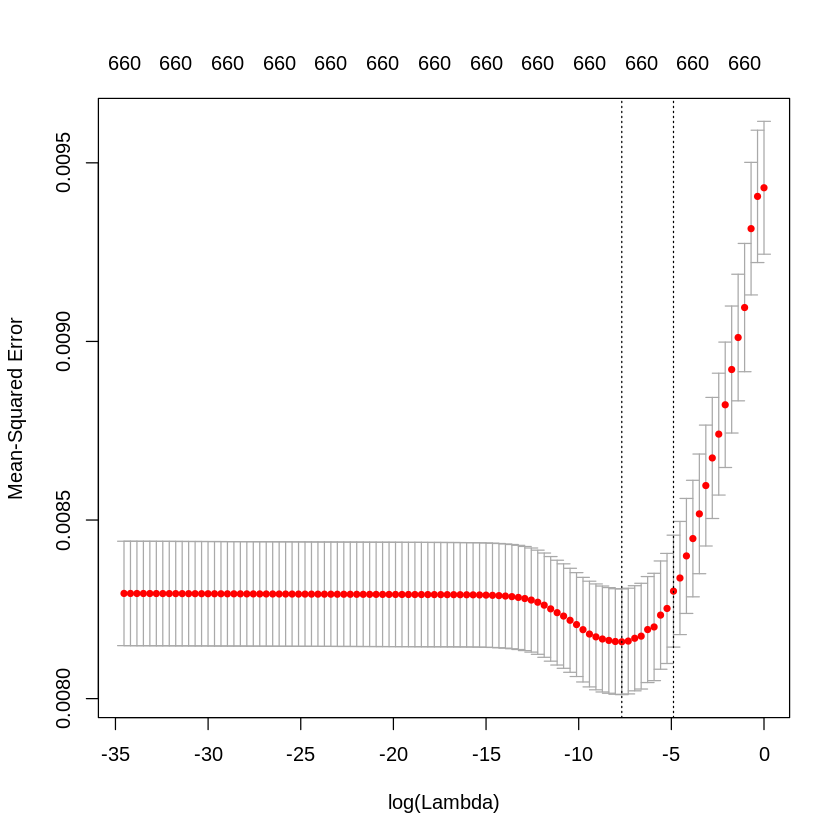

In [16]:
set.seed(0)
#X==predictor
#y==response

y <- ATAC_val %>%  as.matrix()
X <- sum_control_ATAC_bin_rm_gaussian_mean %>% as.matrix()

lambdas_to_try <- 10^seq(-15, -0, length.out = 100)
#standardize = FALSE -- range -15 0
#standardize = TRUE -- range 


ridge_cv_smooth <- cv.glmnet(X, y, alpha = 0, lambda = lambdas_to_try,
                      standardize = TRUE, nfolds = 10)

#Plotting the MSE and log(lambda)

plot(ridge_cv_smooth)

In [17]:
lambda_cv_ridge_smooth <- ridge_cv_smooth$lambda.min

In [18]:
CV_ridge_smooth<-function(data, nfolds){
    set.seed(0)
    cvfolds <- cut(1:nrow(data), breaks = nfolds, labels = F)
    cvfolds <- sample(cvfolds)
    

    predicted <- rep(NA, nrow(data))
    #data_as_matrix <- data %>% dplyr::select(-ATAC_val) %>% as.matrix() 
    
    y <- ATAC_val %>%  as.matrix()
    X <- sum_control_ATAC_bin_rm_gaussian_mean %>% as.matrix()
    
    for (i in 1:nfolds){
        rows      <- which(cvfolds==i)
        testdata  <- X[rows,]
        traindata <- X[-rows,]
        train_y <- y[-rows,]

        fit       <- glmnet(traindata, train_y, alpha = 0, lambda = lambda_cv_ridge_smooth, standardize = TRUE)
        tmp       <- predict(fit, s=lambda_cv_ridge_smooth, testdata)
        predicted[rows] <- tmp
    }
    
    rm(tmp)
    observed <- y
    head(observed)
    mean(observed)
    se    <- (observed-predicted)^2
    mse   <- mean(se)
    (rmse <- sqrt(mse))
    
    return(tibble(observed = observed, predicted = predicted))
}

In [19]:
res_ridge_smooth_gaussian_pred <- CV_ridge_smooth(sum_control_ATAC_bin_rm_gaussian_mean, 10)

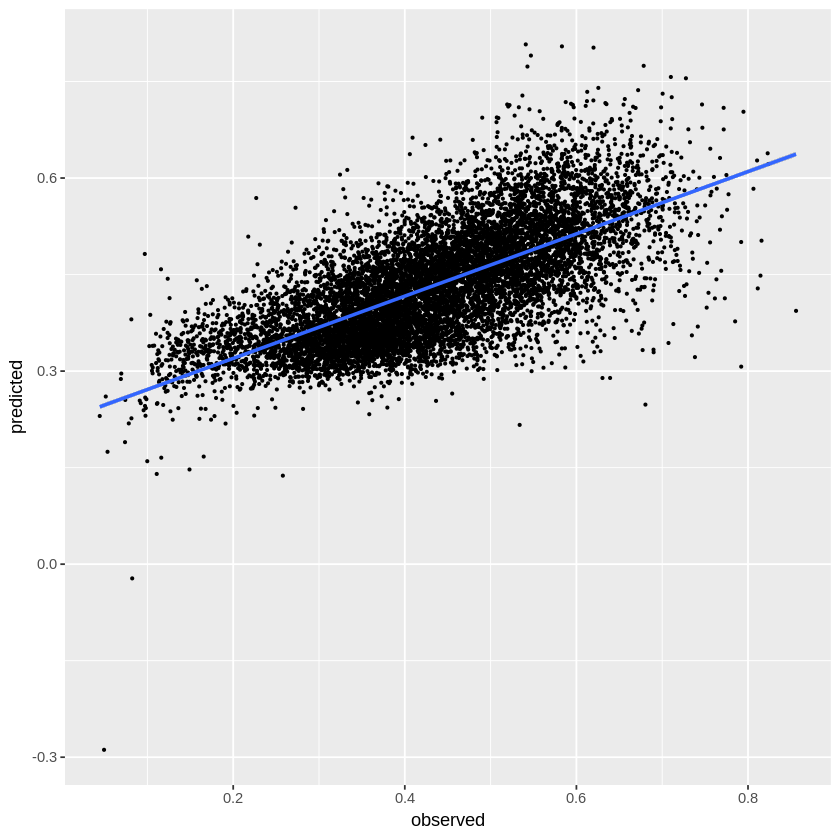

In [20]:
ggplot(res_ridge_smooth_gaussian_pred, aes(x = observed, y = predicted)) + 
    geom_point(size = 0.5) + 
    geom_smooth(method = "lm", formula = y~x)

In [21]:
cor(res_ridge_smooth_gaussian_pred$observed, res_ridge_smooth_gaussian_pred$predicted)

# Standardize = TRUE: ATAC_val 0.6912355
# Standardize = FALSE: ATAC_val 0.696296


ATAC_val,0.6912355
